# Toward Trainability of Deep Quantum Neural Networks

[[2112.15002] Toward Trainability of Deep Quantum Neural Networks](https://arxiv.org/abs/2112.15002)のscikit-qulacs実装例です。

## インポート
`scikit-qulacs`の`QNNClassifier`と`create_dqn_cl`をインポートします。`numpy`や`matplotlib.pyplot`等も併せてインポートします。

In [14]:
import csv
from typing import Tuple

import numpy as np
from qulacs import Observable
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

from skqulacs.circuit.pre_defined import create_dqn_cl, create_dqn_cl_no_cz
from skqulacs.qnn.classifier import QNNClassifier
from skqulacs.qnn.solver import Adam


## テストデータの生成
[UCI Machine Learning Repository](https://archive-beta.ics.uci.edu/ml/datasets/wine)を使用してテストデータを生成します。

In [15]:
# Use wine dataset retrieved from: https://archive-beta.ics.uci.edu/ml/datasets/wine
def load_dataset(
    file_path: str, ignore_kind: int, test_ratio: float
) -> Tuple[np.array, np.array, np.array, np.array]:
    """Load dataset from specified path.

    Args:
        file_path: File path from which data is loaded.
        ignore_kind: The dataset expected to have 3 classes and we need 2 classes to test. So specify here which class to ignore in loading.
    """
    x = []
    y = []
    with open(file_path) as f:
        reader = csv.reader(f)
        for row in reader:
            kind = int(row[0])
            if kind == ignore_kind:
                continue
            y.append(kind)
            x.append([float(feature) for feature in row[1:]])

    x_train, x_test, y_train, y_test = train_test_split(
        x, y, test_size=test_ratio, shuffle=True
    )

    return x_train, x_test, y_train, y_test


## 分類回路の作成
`QNNClassifier`を使用して分類回路を作成します。
第一引数に回路を指定します。第二引数に分類数を指定します。ここでは二値問題のため2を指定してください。  
第三引数に探索アルゴリズムを指定します。`Adam`を指定してください。
`create_classifier()`の第一引数は量子ビット数を指定してください。第二引数に学習用回路を指定してください。
学習用回路はこの後作成します。

In [16]:
def create_classifier(n_features, circuit):
    # Observables are hard-coded in QNNClassifier, so overwrite here.
    classifier = QNNClassifier(circuit, 2, Adam())
    classifier.observables = [Observable(n_features) for _ in range(n_features)]
    for i in range(n_features):
        if i < locality:
            classifier.observables[i].add_operator(1.0, f"Z {i}")
        else:
            classifier.observables[i].add_operator(1.0, f"I {i}")
    return classifier


## 実行
`load_dataset()`を呼び出してテストデータを生成します。
`create_dqn_cl()`で学習用回路を作成し、`create_classifier()`に渡して、分類回路を作成します。
`qcl.fit()`を実行し学習を行います。  
`qcl.predict()`で推論を行います。  
`sklearn.metrics`の`f1_score`を使用して結果の精度を計算します。

In [17]:
x_train, x_test, y_train, y_test = load_dataset("../../../datasets/wine.data", 3, 0.5)

for i in range(len(y_train)):
    y_train[i] -= 1
for i in range(len(y_test)):
    y_test[i] -= 1

n_features = 13
locality = 2
maxiter = 5

print("CL")
circuit = create_dqn_cl(n_features, 5, locality)
classifier = create_classifier(n_features, circuit)
result_cl = []
loop_size = 80
for i in range(loop_size):
    classifier.fit(np.array(x_train), np.array(y_train), maxiter)
    y_pred = classifier.predict(np.array(x_test))
    score = f1_score(y_test, y_pred, average="weighted")
    result_cl.append(score)
    print("iteration:", (i + 1) * maxiter, " score:", score)

print("no CL")
circuit = create_dqn_cl_no_cz(n_features, 5)
classifier = create_classifier(n_features, circuit)
result_no_cl = []
for i in range(loop_size):
    classifier.fit(np.array(x_train), np.array(y_train), maxiter)
    y_pred = classifier.predict(np.array(x_test))
    score = f1_score(y_test, y_pred, average="weighted")
    result_no_cl.append(score)
    print("iteration:", (i + 1) * maxiter, " score:", score)


CL
iteration: 5  score: 0.28481262327416174
iteration: 10  score: 0.6028136727487844
iteration: 15  score: 0.770327320576786
iteration: 20  score: 0.8008593936500358
iteration: 25  score: 0.8466696139109934
iteration: 30  score: 0.8773356911287946
iteration: 35  score: 0.8925147431275766
iteration: 40  score: 0.9080017683465961
iteration: 45  score: 0.9080017683465961
iteration: 50  score: 0.9080017683465961
iteration: 55  score: 0.9234074590961676
iteration: 60  score: 0.9234074590961676
iteration: 65  score: 0.9386678455643973
iteration: 70  score: 0.9539348899118185
iteration: 75  score: 0.9539348899118185
iteration: 80  score: 0.9539348899118185
iteration: 85  score: 0.9539348899118185
iteration: 90  score: 0.9693339227821987
iteration: 95  score: 0.9693339227821987
iteration: 100  score: 0.9693339227821987
iteration: 105  score: 0.9693339227821987
iteration: 110  score: 0.9693339227821987
iteration: 115  score: 0.9693339227821987
iteration: 120  score: 0.9693339227821987
iteration

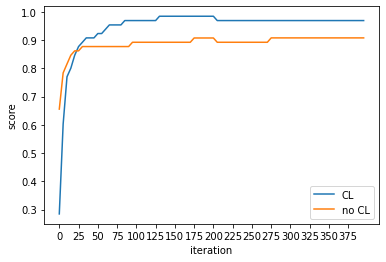

In [21]:
import matplotlib.pyplot as plt

plt.plot(np.arange(0, loop_size*maxiter, step=maxiter), np.array(result_cl).flatten(), label="CL")
plt.plot(np.arange(0, loop_size*maxiter, step=maxiter), np.array(result_no_cl).flatten(), label="no CL")
plt.xticks(np.arange(0, loop_size*maxiter, step=25))
plt.xlabel("iteration")
plt.ylabel("score")
plt.legend()
plt.show()


CLレイヤをつけた回路の方が速く学習が進みます。